In [3]:
%matplotlib inline
%load_ext autoreload

import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import numpy as np
import cartopy.crs as ccrs
import regionmask
import pandas as pd
from datetime import datetime, timedelta
from scipy import signal

import sys

sys.path.insert(0, '/net/fs11/d0/emfreese/BC-IRF')
import utils

import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'all_countries_step': array(1.65179026e+10),
 'all_countries_add': array(2.53307545e+08),
 'all_countries_pulse': array(16809173.13352966)}

## Import Data

In [5]:
## Global mean

#global mean green's function
G_mean = xr.open_dataset(f'{utils.data_output_path}validation/Greens_function_mean_step_v_pulse.nc')['__xarray_dataarray_variable__']
#global mean concentration change
ds_conc_mean = xr.open_dataset(f'{utils.data_output_path}validation/concentration_mean_step_v_pulse.nc')
#global mean surface level green's function
G_lev0 = xr.open_dataset(f'{utils.data_output_path}validation/Greens_function_lev0_mean_step_v_pulse.nc')['__xarray_dataarray_variable__'].isel(lev = 0)
#global mean surface level concentration
ds_conc_lev0 = xr.open_dataset(f'{utils.data_output_path}validation/concentration_lev0_mean_step_v_pulse.nc')

## Spatially disaggregated

#concentration change
ds_conc = xr.open_dataset(f'{utils.data_output_path}validation/concentration_step_v_pulse.nc')
#Green's function
G = xr.open_dataset(f'{utils.data_output_path}validation/Greens_function_step_v_pulse.nc')['__xarray_dataarray_variable__']


## Emissions
#emissions
ds_emis = xr.open_dataset(f'{utils.data_output_path}ds_emis_step_v_pulse.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'/net/fs11/d0/emfreese/BC-IRF/data_output/validation/Greens_function_mean_step_v_pulse.nc'

## Surface plot

Text(0, 0.5, "Green's Function")

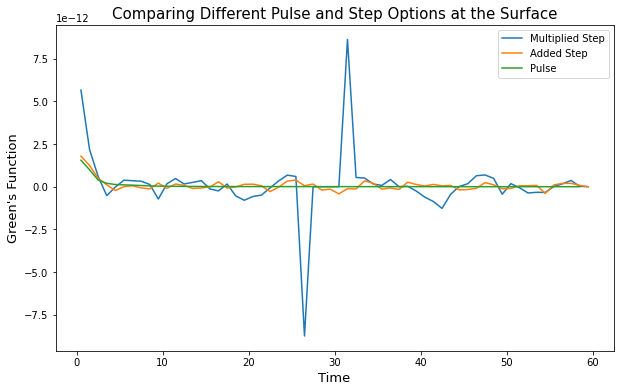

In [13]:
fig, ax = plt.subplots(figsize = [10,6])
G_lev0.sel(run = 'all_countries_step').plot(label = 'Multiplied Step')
G_lev0.sel(run = 'all_countries_add').plot(label = 'Added Step')
(G_lev0.sel(run = 'all_countries_pulse')).plot(label = 'Pulse')
plt.legend()
plt.title('Comparing Different Pulse and Step Options at the Surface', fontsize = 15)
plt.xlabel('Time', fontsize = 13)
plt.ylabel('Green\'s Function', fontsize = 13)

## Global Mean Plot

Text(0, 0.5, "Green's Function")

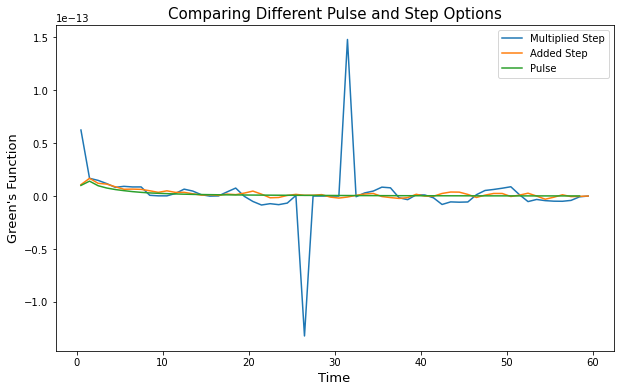

In [14]:
fig, ax = plt.subplots(figsize = [10,6])
G_mean.sel(run = 'all_countries_step').plot(label = 'Multiplied Step')
G_mean.sel(run = 'all_countries_add').plot(label = 'Added Step')
(G_mean.sel(run = 'all_countries_pulse')).plot(label = 'Pulse')
plt.legend()
plt.title('Comparing Different Pulse and Step Options', fontsize = 15)
plt.xlabel('Time', fontsize = 13)
plt.ylabel('Green\'s Function', fontsize = 13)

## Compare convolution to the actual 2x output

In [21]:
#emis = kg/day
#conc = μg m-3

In [22]:
## Calculate the emissions difference between the 'all countries' and 'base' scenario
emis_dif_2x = (ds_emis.sel(run = 'all_countries_add')-ds_emis.sel(run = 'base')).weighted(ds_emis['area'].sel(run = 'base').fillna(0)).sum(dim = ['lat','lon'])['EmisBC_Total']
utils.switch_conc_time(emis_dif_2x)

In [23]:
## Convolution for the mean surface level
conv_2x = {}
for run in G_lev0.run.values:
    conv_2x[run] = signal.convolve(np.array(G_lev0.sel(run = run)) , np.array(emis_dif_2x.values), mode = 'full')


In [24]:
## Convolution for the global pulse run
conv_2x_full = {}
for run in ['all_countries_pulse']:
    conv_2x_full[run] = signal.convolve(np.array(G.sel(run = run).isel(lev = 0).fillna(0)) , np.array(emis_dif_2x.values)[...,None,None], mode = 'full')
conv_2x_full = utils.np_to_xr(conv_2x_full[run], G.sel(run = run).isel(lev = 0), np.array(emis_dif_2x.values))

In [ ]:
####### LEFT OFF HERE !!!!!!!!!!!!! #########

In [27]:
f0_step = 1.65179026e+10 #(ds_emis.sel(run = 'all_countries_step')-ds_emis.sel(run = 'base')).weighted(ds_emis['area'].fillna(0).sel(run = 'base')).sum(dim = ['lat','lon'])['EmisBC_Total'].isel(time = 0)

In [72]:
country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
country_impacted = 'China'

mask = country_mask.mask(ds_conc, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(country_impacted))
country_impacted_ds = conv_2x_full.where(contiguous_mask).weighted(ds_conc['area'].isel(run = 0, time = 0).fillna(0)).mean(dim = ['lat','lon'])
#dif_country_impacted_ds = ds_conc.where(contiguous_mask).weighted(ds_conc['area'].isel(run = 0, time = 0).fillna(0)).mean(dim = ['lat','lon'])

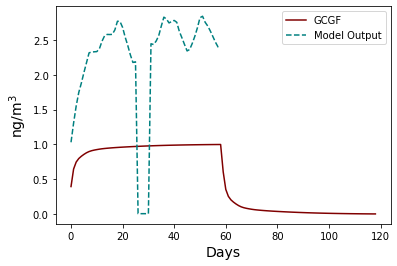

In [36]:
fig,ax = plt.subplots()
plt.plot(conv_2x_full.weighted(ds_conc['area'].isel(time = 0, run = 0)).mean(dim = ['lat','lon'])*1e3, label = 'GCGF', color = 'maroon')

plt.plot((ds_conc_mean.sel(run = 'all_countries_step') - ds_conc_mean.sel(run = 'base'))['BC_total']*1e3, linestyle = '--', label = 'Model Output', color = 'teal')
# plt.plot(((ds_conc_lev0.sel(run = 'all_countries_step')-ds_conc_lev0.sel(run = 'base'))/f0_step)['BC_total']*emis_dif_2x, label = 'pattern scale')
plt.plot()
plt.xlabel('Days', fontsize = 14)
plt.ylabel('ng/m$^3$', fontsize = 14)

plt.legend()
#plt.savefig('figures/paper/GCGF_recreation.png', bbox_inches = 'tight', dpi = 350)

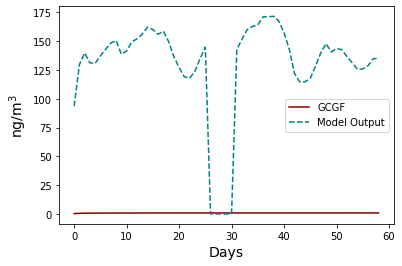

In [83]:
fig,ax = plt.subplots()
for r in ['all_countries_pulse']:
    plt.plot(conv_2x[r]*1e3, label = 'GCGF', color = 'maroon')

plt.plot((ds_conc_lev0.sel(run = 'all_countries_step') - ds_conc_lev0.sel(run = 'base'))['BC_total']*1e3, linestyle = '--', label = 'Model Output', color = 'teal')
# plt.plot(((ds_conc_lev0.sel(run = 'all_countries_step')-ds_conc_lev0.sel(run = 'base'))/f0_step)['BC_total']*emis_dif_2x, label = 'pattern scale')
plt.plot()
plt.xlabel('Days', fontsize = 14)
plt.ylabel('ng/m$^3$', fontsize = 14)

plt.legend()
plt.savefig('figures/paper/GCGF_recreation.png', bbox_inches = 'tight', dpi = 350)

## Compare to complex pulse run

In [50]:
emis_dif_cos = (ds_emis.sel(run = 'Indo_cos')-ds_emis.sel(run = 'base')).weighted(ds_emis['area'].sel(run = 'base').isel(time = 0)).sum(dim = ['lat','lon'])['EmisBC_Total']
utils.switch_conc_time(emis_dif_cos)

In [51]:
ds_emis_dif = (ds_emis.sel(run = 'Indo_cos')-
 ds_emis.sel(run = 'base'))
utils.switch_conc_time(ds_emis_dif)

In [53]:
emis_dif_cos_pulse = {}

country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_50
countries = ['Cambodia','Malaysia','Vietnam','Indonesia']

mask = country_mask.mask(ds_emis_dif, lon_name = 'lon', lat_name = 'lat')
for country_impacted in countries:
    contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(country_impacted))
    emis_dif_cos_pulse[country_impacted] = ds_emis_dif.where(contiguous_mask)
    emis_dif_cos_pulse[country_impacted] = emis_dif_cos_pulse[country_impacted].weighted(ds_emis['area'].sel(run = 'base').isel(time = 0)).sum(dim = ['lat','lon'])['EmisBC_Total']

In [ ]:
ds_emis_dif.isel(time = 1)['EmisBC_Total'].plot()

In [54]:
G_all = xr.open_dataset(f'{utils.data_output_path}G_combined_new.nc')



In [57]:
country_dict = {'Malaysia':'Malay_Jan',
               'Indonesia':'Indo_Jan',
               'Vietnam':'Viet_Jan',
               'Cambodia':'Cambod_Jan'}



In [63]:
G_cos_pulse = G_all.sel(run = list(country_dict.values())).isel(lev = 0).weighted(ds_emis['area'].sel(run = 'base').isel(time = 0)).mean(dim = ['lat','lon'])

In [91]:

conv_cos_pulse = {}
for loc in country_dict.keys():
    conv_cos_pulse[loc] = signal.convolve(np.array(G_cos_pulse.sel(run = country_dict[loc])['BC_total'].dropna(dim = 'time')) , 
                                          np.array(emis_dif_cos_pulse[loc].dropna(dim = 'time').values), mode = 'full')


In [92]:
pulse = conv_cos_pulse['Malaysia'] + conv_cos_pulse['Indonesia'] + conv_cos_pulse['Cambodia'] + conv_cos_pulse['Vietnam'] 

In [94]:
conv_cos = {}
for run in G_lev0.run.values:
    conv_cos[run] = signal.convolve(np.array(G_lev0.sel(run = run)) , np.array(emis_dif_cos.values), mode = 'full')


(0.0, 25.0)

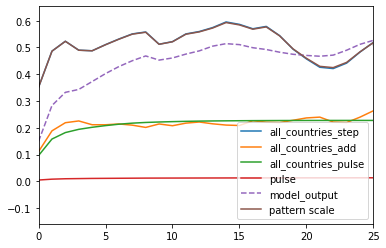

In [95]:
fig,ax = plt.subplots()
for r in conv_cos.keys():
    plt.plot(conv_cos[r], label = r)
plt.plot(pulse, label = 'pulse')
plt.plot((ds_conc_lev0.sel(run = 'Indo_cos') - ds_conc_lev0.sel(run = 'base'))['BC_total'], linestyle = '--', label = 'model_output')
plt.plot(((ds_conc_lev0.sel(run = 'all_countries_step')-ds_conc_lev0.sel(run = 'base'))/f0_step)['BC_total']*emis_dif_cos, label = 'pattern scale')
plt.plot()
plt.legend()
plt.xlim(0,25)